In [1]:
import argparse as argp
import os
import sys
import time
from copy import deepcopy
from importlib import import_module

import jax
import jax.numpy as jnp
import minkasi
import mpi4jax
import numpy as np
import yaml
from jitkasi.tod import TOD
from mpi4py import MPI
from typing_extensions import Any, Unpack

import witch.utils as wu
from witch.containers import Model
from witch.fitting import fit_tods, objective
from witch.external.minkasi.utils import from_minkasi, from_minkasi_noise, from_minkasi_tod, to_minkasi
from witch.fitter import load_config, get_outdir, process_tods

comm = MPI.COMM_WORLD.Clone()

import pdb
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

mpi4py imported
nproc:,  1


In [2]:

#path = "/home/jorlo/dev/minkasi_jax/configs/MOOJ1142/MOOJ1142_SHOCK.yaml"
#path = "/home/jorlo/dev/minkasi_jax/unit_tests/cyl_unit.yaml"
path = "/home/jorlo/dev/minkasi_jax/unit_tests/non_para.yaml"

with open(path, "r") as file:
    cfg = yaml.safe_load(file)
if "models" not in cfg:
    cfg["models"] = {}

fit = True

In [3]:
cfg = load_config({}, path)
cfg["fit"] = cfg.get("fit", "model" in cfg)
cfg["sim"] = cfg.get("sim", False)
cfg["wnoise"] = cfg.get("wnoise", False)
cfg["map"] = cfg.get("map", True)
cfg["sub"] = cfg.get("sub", True)

cfg["sim"] = False
# Do imports
for module, name in cfg.get("imports", {}).items():
    mod = import_module(module)
    if isinstance(name, str):
        locals()[name] = mod
    elif isinstance(name, list):
        for n in name:
            locals()[n] = getattr(mod, n)
    else:
        raise TypeError("Expect import name to be a string or a list")

In [4]:
# Get the functions needed to work with out dataset
# TODO: make protocols for these and check them
dset_name = list(cfg["datasets"].keys())[0]
load_tods = eval(cfg["datasets"][dset_name]["funcs"]["load_tods"])
get_info = eval(cfg["datasets"][dset_name]["funcs"]["get_info"])
make_beam = eval(cfg["datasets"][dset_name]["funcs"]["make_beam"])
preproc = eval(cfg["datasets"][dset_name]["funcs"]["preproc"])
postproc = eval(cfg["datasets"][dset_name]["funcs"]["postproc"])
postfit = eval(cfg["datasets"][dset_name]["funcs"]["postfit"])

# Get TODs
todvec = load_tods(dset_name, cfg, comm)

# Get any info we need specific to an expiriment
info = get_info(dset_name, cfg, todvec)

# Get the beam
beam = make_beam(dset_name, cfg, info)

# Define the model and get stuff setup fitting
if "model" in cfg:
    model = Model.from_cfg(cfg, beam)
else:
    model = None
    print_once("No model defined, setting fit, sim, and sub to False")
    cfg["fit"] = False
    cfg["sim"] = False
    cfg["sub"] = False

# Setup noise
noise_class = eval(str(cfg["datasets"][dset_name]["noise"]["class"]))
noise_args = tuple(eval(str(cfg["datasets"][dset_name]["noise"]["args"])))
noise_kwargs = eval(str(cfg["datasets"][dset_name]["noise"]["kwargs"]))
info["noise_class"] = noise_class
info["noise_args"] = noise_args
info["noise_kwargs"] = noise_kwargs

# Get output
if "base" in cfg.keys():
    del cfg["base"]  # We've collated to the cfg files so no need to keep the base
outdir = get_outdir(cfg, model)
info["outdir"] = outdir

# Process the TODs
preproc(dset_name, cfg, todvec, model, info)
todvec = process_tods(cfg, todvec, noise_class, noise_args, noise_kwargs, model)
copy_noise = info["copy_noise"]
todvec = to_minkasi(todvec, copy_noise)

deleted  0  bad files.
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  72 23691 72  on  /mnt/welch/MUSTANG/M2-TODs/RXJ1347/Signal_TOD-AGBT16A_473_02-s134.fits with lims  206.79301 206.94154 -11.834224 -11.675019
truncating from  23691  to  23626
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  76 9219 76  on  /mnt/welch/MUSTANG/M2-TODs/RXJ1347/Signal_TOD-AGBT16A_473_02-s135.fits with lims  206.79442 206.92502 -11.828844 -11.675086
truncating from  9219  to  9217
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  166 23691 166  on  /mnt/welch/MUSTANG/M2-TODs/RXJ1347/Signal_TOD-AGBT17A_358_03-s34.fits with lims  206.7963

In [5]:
lims = todvec.lims()
pixsize = 2.0 / 3600 * np.pi / 180
skymap = minkasi.maps.SkyMap(lims, pixsize)

for tod in todvec.tods:
    ipix=skymap.get_pix(tod)
    tod.info['ipix']=ipix
    tod.set_noise(minkasi.mapmaking.noise.NoiseSmoothedSVD)

got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd


In [6]:
# Make maps
npass = 1
dograd = True
# get the hit count map.  We use this as a preconditioner
# which helps small-scale convergence quite a bit.
hits = minkasi.mapmaking.make_hits(todvec, skymap)
naive = skymap.copy()
naive.clear()
for tod in todvec.tods:
    tmp = tod.info["dat_calib"].copy()
    u, s, v = np.linalg.svd(tmp, 0)
    pred = np.outer(u[:, 0], s[0] * v[0, :])
    tmp = tmp - pred
    naive.tod2map(tod, tmp)
naive.mpi_reduce()
naive.map[hits.map > 0] = naive.map[hits.map > 0] / hits.map[hits.map > 0]
if minkasi.myrank == 0:
    naive.write(os.path.join(outdir, "naive.fits"))
    hits.write(os.path.join(outdir, "hits.fits"))
hits_org = hits.copy()
hits.invert()

# setup the mapset.  In general this can have many things
# in addition to map(s) of the sky, but for now we'll just
# use a single skymap.
weightmap = minkasi.mapmaking.make_hits(todvec, skymap, do_weights=True)
mask = weightmap.map > 0
tmp = weightmap.map.copy()
tmp[mask] = 1.0 / np.sqrt(tmp[mask])
noisemap = weightmap.copy()
noisemap.map[:] = tmp
if minkasi.myrank == 0:
    noisemap.write(os.path.join(outdir, "noise.fits"))
    weightmap.write(os.path.join(outdir, "weights.fits"))

mapset = minkasi.maps.Mapset()
mapset.add_map(skymap)

# make A^T N^1 d.  TODs need to understand what to do with maps
# but maps don't necessarily need to understand what to do with TODs,
# hence putting make_rhs in the vector of TODs.
# Again, make_rhs is MPI-aware, so this should do the right thing
# if you run with many processes.
rhs = mapset.copy()
todvec.make_rhs(rhs)

# this is our starting guess.  Default to starting at 0,
# but you could start with a better guess if you have one.
x0 = rhs.copy()
x0.clear()

# preconditioner is 1/ hit count map.  helps a lot for
# convergence.
precon = mapset.copy()
precon.maps[0].map[:] = hits.map[:]

In [7]:
# run PCG

iters = [5, 25, 50]
mapset_out = minkasi.mapmaking.run_pcg_wprior(
    rhs,
    x0,
    todvec,
    None,
    precon,
    maxiter=50,
    outroot=os.path.join(outdir, "noprior"),
    save_iters=iters,
)


[0.00555682 0.06936216 0.00421238]
0 3956385436.378187 0.08143210411071777
[0.0056107  0.06828332 0.0041852 ]
1 396800661.53552014 1.5733336256877448e-05 0.07869601249694824 0.0017306804656982422 0.08042669296264648 46.56084703328638
[0.00555873 0.06864953 0.00442314]
2 103752002.38153194 9.346280237864766e-06 0.07921290397644043 0.0016295909881591797 0.08084249496459961 46.25702147076688
[0.00537395 0.06867766 0.00462532]
3 33791346.54224523 1.0274246640907728e-05 0.07918310165405273 0.0015938282012939453 0.08077692985534668 46.27443133016578
[0.00561261 0.06848121 0.00415039]
4 15081208.569832306 1.1279686219370212e-05 0.07879757881164551 0.0014700889587402344 0.08026766777038574 46.50083232580839
[0.00559616 0.06885529 0.00453043]
5 6793402.610076057 1.102677512377541e-05 0.07947278022766113 0.0015306472778320312 0.08100342750549316 46.10576085929686
[0.00544    0.06883407 0.00417948]
6 3140024.491325834 1.1869318193761932e-05 0.07893991470336914 0.0015716552734375 0.080511569976806

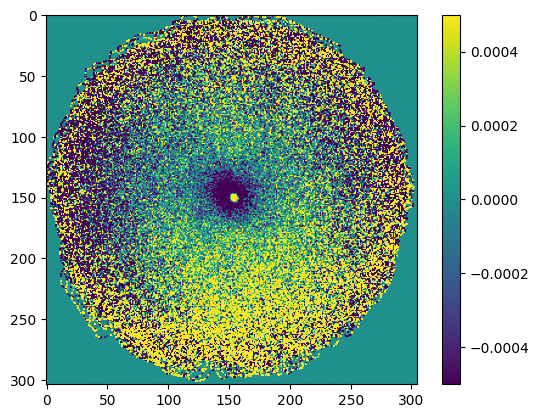

-0.00987868110587631


In [8]:

cur_map = mapset_out.maps[0].map#naive.map #

lim = 5e-4
plt.imshow(cur_map, vmin = -lim, vmax = lim)
plt.colorbar()
plt.show()
print(np.amin(cur_map[200:300, 150:250]))


0.0


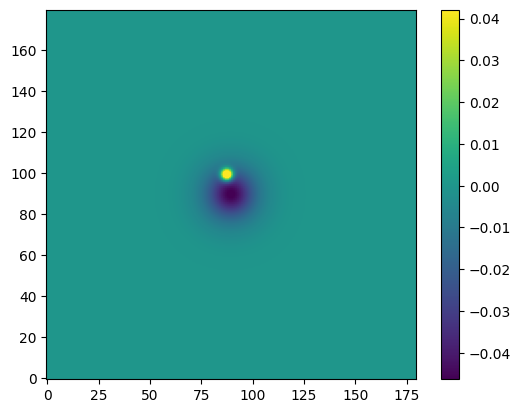

In [29]:
path = "/home/jorlo/dev/minkasi_jax/configs/MOOJ1142/MOOJ1142_nonpara.yaml"

with open(path, "r") as file:
    cfg = yaml.safe_load(file)
if "models" not in cfg:
    cfg["models"] = {}

cfg = load_config({}, path)


# Define the model and get stuff setup fitting
if "model" in cfg:
    model = Model.from_cfg(cfg, beam)

vis_model = model.model

plt.imshow(vis_model, vmin = -lim, vmax = lim, origin="lower")
plt.colorbar()
plt.show()

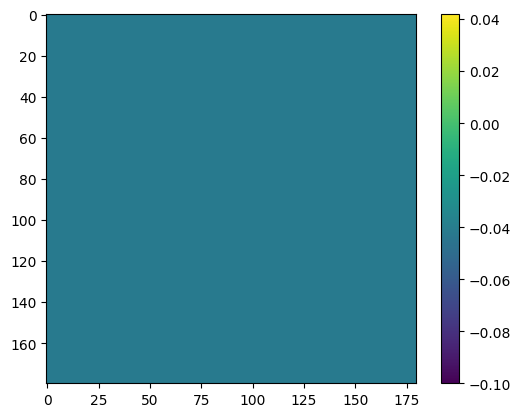

In [10]:
from witch.core import stage2_model

vis_model = stage2_model(model.xyz, 
                   tuple(model.n_struct),
                   model.dz,
                   model.beam,
                   *model.pars,
        )
lim = np.amin(vis_model)

plt.imshow(vis_model, vmin = -lim, vmax = 0)
plt.colorbar()
plt.show()

In [30]:
np.amax(model.model)

Array(0.07429812, dtype=float64)